# A Better Zestimate

## Project Planning

### Goals

I will develop a model to predict the log error that is the log of the difference between the Zestimate and the sales price of a home. I will achieve this by analyzing available home and sales data in order to identify drivers of home values. I hope to arrive at one or more theories related to causal relationships around home evaluation.

### Deliverables

1. *A report (in the form of a presentation, both verbal and through a slides) that summarizes your findings about the drivers of the Zestimate error. This will come from the analysis I do during the exploration phase of the pipeline. In the report, I will have charts that visually tell the story of what is driving the errors.*

2. *A Jupyter notebook, titled 'Regression_Proj_YourName', that contains a clearly labeled section and code clearly documented for each the stages below (project planning, data acquisition, data prep, exploration, and modeling). All of the work will take place in my jupyter notebook.*

### Data Dictionary & Details

**using 2016 data only** (NOT properties_2017 or predictions_2017)

- error:  the difference of the sales price and the Zestimate
- logerror:  computed by taking the log function of that error
- bathroomcnt:   Number of bathrooms in home including fractional bathrooms
- bedroomcnt:   Number of bedrooms in home 
- calculatedfinishedsquarefeet:   Calculated total finished living area of the home
- fullbathcnt:   Number of full bathrooms (sink, shower + bathtub, and toilet) present in home
- garagecarcnt:   Total number of garages on the lot including an attached garage
- roomcnt:   Total number of rooms in the principal residence!
- yearbuilt:   The Year the principal residence was built 
- landtaxvaluedollarcnt:  The assessed value of the land area of the parcel
- taxamount:  The total property tax assessed for that assessment year
- regionidzip:   Zip code in which the property is located

### Initial Thoughts, Ideas, Hypotheses

Brainstorming ideas, hypotheses, related to how variables might impact or relate to each other, both within independent variables and between the independent variables and dependent variable, and also related to any ideas for new features you may have while first looking at the existing variables and challenge ahead of you.

### Prepare your environment

import libraries you will use throughout the project.  You may need to add to this as you go.  But try to keep all of your imports in this section

In [1]:
# Wrangling
import pandas as pd
from pydataset import data # data is a function that gives a dataframe
from sqlalchemy import create_engine
import numpy as np
from env import path

# Exploring
import scipy.stats as stats

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Modeling
import statsmodels.api as sm

from scipy.stats import pearsonr
from scipy.stats import iqr
from scipy.stats import ttest_ind

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

### Data Acquisition

#### Acquire via csv

- add the path to where your files are located in your env.py file. 
- ensure that others can read the files based on their local env.py file. 

- Filter out any from predictions_2016 that do not have a logerror. 
- Generate a cohesive data set that includes the following fields:

- `logerror`
- `bathroomcnt`
- `bedroomcnt`
- `calculatedfinishedsquarefeet`
- `fullbathcnt`
- `garagecarcnt`
- `roomcnt`
- `yearbuilt`
- `taxvaluedollarcnt`
- `taxamount`
- (optional) `regionidzip`

recommendations for dealing with the large dataset
- remove any without a logerror (meaning the logerror value is missing)
- Maggie gave us the csv file... but normally would...
    - sample until you have the right query (and then pull entire dataset)
    - export to local csv 
- read from local csv (sample, but larger sample than your first) 
- save sql query to add into to_sql() function in python. 

In [2]:
# Read in the property and predictions data, which I acquired
# as two files. I will then join them.
properties_df = pd.read_csv(path + "properties_2016.csv", low_memory=False)
predictions_df = pd.read_csv(path + "predictions_2016.csv", low_memory=False)

#### Summarize the data. 

Why? So you can confirm the data look like what you would expect.

- peek at a few rows
- data types
- summary stats
- column names
- number of rows and columns
- ...

In [3]:
properties_df.dtypes

parcelid                          int64
airconditioningtypeid           float64
architecturalstyletypeid        float64
basementsqft                    float64
bathroomcnt                     float64
bedroomcnt                      float64
buildingclasstypeid             float64
buildingqualitytypeid           float64
calculatedbathnbr               float64
decktypeid                      float64
finishedfloor1squarefeet        float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
finishedsquarefeet13            float64
finishedsquarefeet15            float64
finishedsquarefeet50            float64
finishedsquarefeet6             float64
fips                            float64
fireplacecnt                    float64
fullbathcnt                     float64
garagecarcnt                    float64
garagetotalsqft                 float64
hashottuborspa                   object
heatingorsystemtypeid           float64
latitude                        float64


In [4]:
predictions_df.dtypes

parcelid             int64
logerror           float64
transactiondate     object
dtype: object

In [5]:
# Merge the two files
full_df = properties_df.merge(predictions_df, on='parcelid', how='inner')
full_df.head(3)

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate
0,17073783,NaN,NaN,NaN,2.5,3.0,NaN,NaN,2.5,NaN,...,115087.0,191811.0,2015.0,76724.0,2015.06,NaN,NaN,6.111002e+13,0.0953,2016-01-27
1,17088994,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,...,143809.0,239679.0,2015.0,95870.0,2581.30,NaN,NaN,6.111002e+13,0.0198,2016-03-30
2,17100444,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,33619.0,47853.0,2015.0,14234.0,591.64,NaN,NaN,6.111001e+13,0.0060,2016-05-27


#### Identify the data types of each variable. Why? 
You need to make sure they are what makes sense for the data and the meaning of the data that lies in that variable. If it does not, make necessary changes.

In [6]:
# Select features to examine
df = full_df[['logerror', 'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'fullbathcnt', 'garagecarcnt', 'roomcnt', 'yearbuilt', 'landtaxvaluedollarcnt', 
        'taxamount', 'regionidzip']]
df.dtypes

logerror                        float64
bathroomcnt                     float64
bedroomcnt                      float64
calculatedfinishedsquarefeet    float64
fullbathcnt                     float64
garagecarcnt                    float64
roomcnt                         float64
yearbuilt                       float64
landtaxvaluedollarcnt           float64
taxamount                       float64
regionidzip                     float64
dtype: object

In [7]:
df.shape

(90275, 11)

In [8]:
def summarize_df(df):
    print("Summary of Data\n")
    print("Rows & Columns:\n")
    print(df.shape)
    print("Variables:\n")
    var_names = df.columns.values
    print(var_names)
    print("\nColumn Info:\n")
    print(df.info())
    print("\nNumeric Summary Stats:\n")
    print(df.describe())
    print("\nTop 5 Values:\n")
    for var in var_names:
        print(var+":")
        print(df[var].value_counts().head())
        print('\n')
    print("\nMissing Values:\n")
    null_counts = df.isnull().sum()
    if len(null_counts[null_counts > 0]) == 0:
        print("No missing values")
    else:
        print(null_counts[null_counts > 0])
    print("\nFirst 5 rows:\n")
    print(df.head())
    print("\nEnd of Summary")

In [9]:
summarize_df(df)

Summary of Data

Rows & Columns:

(90275, 11)
Variables:

['logerror' 'bathroomcnt' 'bedroomcnt' 'calculatedfinishedsquarefeet'
 'fullbathcnt' 'garagecarcnt' 'roomcnt' 'yearbuilt'
 'landtaxvaluedollarcnt' 'taxamount' 'regionidzip']

Column Info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Data columns (total 11 columns):
logerror                        90275 non-null float64
bathroomcnt                     90275 non-null float64
bedroomcnt                      90275 non-null float64
calculatedfinishedsquarefeet    89614 non-null float64
fullbathcnt                     89093 non-null float64
garagecarcnt                    29937 non-null float64
roomcnt                         90275 non-null float64
yearbuilt                       89519 non-null float64
landtaxvaluedollarcnt           90274 non-null float64
taxamount                       90269 non-null float64
regionidzip                     90240 non-null float64
dtypes: float64(11)
memory usage: 8.3 M

### Data Preparation

Goal: leave this section with a dataset that is ready to be analyzed. 

In [10]:
df.isnull().sum()

logerror                            0
bathroomcnt                         0
bedroomcnt                          0
calculatedfinishedsquarefeet      661
fullbathcnt                      1182
garagecarcnt                    60338
roomcnt                             0
yearbuilt                         756
landtaxvaluedollarcnt               1
taxamount                           6
regionidzip                        35
dtype: int64

#### Identify the columns that have missing values and the number of missing values in each column. 
Why? Missing values are going to cause issues down the line so you will need to handle those appropriately. For each variable with missing values, if it makes sense to replace those missing with a 0, do so. For those where that doesn't make sense, decide if you should drop the entire observations (rows) that contain the missing values, or drop the entire variable (column) that contains the missing values.

In [11]:
# dropping garagecarcnt column because 60,338 out of 90,275 rows are null
df = df.drop(columns=['garagecarcnt'])
df.head(2)

,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,roomcnt,yearbuilt,landtaxvaluedollarcnt,taxamount,regionidzip
0,0.0953,2.5,3.0,1264.0,2.0,5.0,1986.0,76724.0,2015.06,97081.0
1,0.0198,1.0,2.0,777.0,1.0,4.0,1990.0,95870.0,2581.30,97083.0


In [12]:
df.sort_values(by=['fullbathcnt'], ascending=False).head(10)
# first entry showed 66 sqft and 20 bathrooms, so dropping that row

,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,roomcnt,yearbuilt,landtaxvaluedollarcnt,taxamount,regionidzip
49230,-0.0325,20.0,3.0,66.0,20.0,0.0,1960.0,68427.0,2831.76,96414.0
87193,-0.3711,15.0,7.0,20013.0,15.0,0.0,2000.0,17056079.0,272407.03,96086.0
42935,-0.0315,12.0,8.0,5440.0,12.0,0.0,2007.0,418040.0,15210.01,96016.0
9678,-1.2040,12.0,0.0,5878.0,12.0,0.0,2002.0,298686.0,8479.29,95988.0
69157,-0.1381,12.0,8.0,4963.0,12.0,0.0,1986.0,54357.0,6310.97,96221.0
13285,-0.1696,11.0,15.0,6476.0,11.0,0.0,1926.0,213200.0,11533.75,96025.0
55103,0.2593,11.0,7.0,11478.0,11.0,0.0,1999.0,9197112.0,181533.24,96086.0
53272,0.1089,11.0,8.0,7865.0,11.0,0.0,1940.0,3940651.0,65200.45,96030.0
61813,0.0935,10.0,7.0,10014.0,10.0,0.0,2014.0,4651108.0,152152.22,96120.0
37525,0.0516,10.0,6.0,18577.0,10.0,0.0,1991.0,3122889.0,109050.78,96086.0


In [13]:
df = df.drop(49230)

In [14]:
df.sort_values(by=['fullbathcnt'], ascending=False).head(2) # confirmed that row deleted

,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,roomcnt,yearbuilt,landtaxvaluedollarcnt,taxamount,regionidzip
87193,-0.3711,15.0,7.0,20013.0,15.0,0.0,2000.0,17056079.0,272407.03,96086.0
42935,-0.0315,12.0,8.0,5440.0,12.0,0.0,2007.0,418040.0,15210.01,96016.0


In [15]:
df.sort_values(by=['bathroomcnt'], ascending=True).head(10) # noticed lots of NaN values

,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,roomcnt,yearbuilt,landtaxvaluedollarcnt,taxamount,regionidzip
40517,0.0129,0.0,0.0,NaN,NaN,0.0,NaN,409844.0,9864.85,96151.0
6721,2.4330,0.0,0.0,NaN,NaN,0.0,NaN,58669.0,900.36,NaN
18984,-0.0910,0.0,0.0,NaN,NaN,0.0,NaN,299217.0,4306.64,96967.0
23248,-0.0020,0.0,0.0,1604.0,NaN,0.0,1966.0,226549.0,3824.72,97003.0
43550,0.0488,0.0,0.0,1328.0,NaN,0.0,1938.0,434110.0,6531.42,96990.0
37709,-0.0060,0.0,0.0,2175.0,NaN,0.0,1910.0,1345125.0,16085.24,96225.0
14877,0.0639,0.0,0.0,NaN,NaN,0.0,NaN,10631.0,3290.86,97329.0
37716,-0.0202,0.0,0.0,4087.0,NaN,0.0,1965.0,187924.0,5261.46,97041.0
14887,0.0080,0.0,0.0,NaN,NaN,0.0,NaN,20300.0,3591.38,97097.0
14889,-0.0502,0.0,0.0,NaN,NaN,0.0,NaN,52977.0,809.57,96356.0


In [16]:
# 2641 cells with null values
df.isnull().sum().sum() 

2641

In [17]:
df.yearbuilt.isnull().sum().sum() # 756 in yearbuilt alone

756

In [18]:
# dropped all rows with nulls in yearbuilt
df = df[df['yearbuilt'].notnull()]
df.yearbuilt.isnull().sum().sum() 

0

#### Create a variable, `colnames`, that is a list of the column names. 
Why? You will likely reference this variable later.

In [19]:
# creating list of column names to use in for loops
# did not include logerror
col_names = ('bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'fullbathcnt', 'yearbuilt', 'landtaxvaluedollarcnt', 'taxamount', 'regionidzip')

In [20]:
# drop rows with NaN in any column
for column in col_names:
    df = df[df[column].notnull()]
df.isnull().sum().sum() 

0

In [21]:
df['roomcnt'].value_counts() #68,481 roomcnts of zero, so dropping roomcnt column

0.0     68481
6.0      5340
7.0      4471
5.0      3480
8.0      3393
4.0      1665
9.0      1353
10.0      364
3.0       269
11.0      108
12.0       32
13.0       11
2.0         6
14.0        4
1.0         3
15.0        2
18.0        1
Name: roomcnt, dtype: int64

In [22]:
df = df.drop(columns=['roomcnt'])
df.shape # dropped from (90275, 11) to (88983, 9)... I'm happy with that.

(88983, 9)

In [23]:
# need to take absolute value of logerrors because it doesn't matter if the error is
# an over or underestimate.
df.logerror = df.logerror.abs()
df.sort_values(by=['logerror'], ascending=True)

,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,yearbuilt,landtaxvaluedollarcnt,taxamount,regionidzip
84927,0.000,3.0,3.0,3282.0,3.0,1967.0,83000.0,5745.66,97329.0
67433,0.000,2.5,3.0,1551.0,2.0,1989.0,360473.0,7084.66,96993.0
67430,0.000,2.5,4.0,1566.0,2.0,1997.0,304393.0,5410.94,96989.0
71478,0.000,3.0,5.0,2852.0,3.0,1965.0,251431.0,5022.56,97020.0
26725,0.000,2.0,3.0,1030.0,2.0,1988.0,69529.0,2411.94,95993.0
56074,0.000,2.0,3.0,2178.0,2.0,1983.0,381220.0,10206.68,96161.0
36006,0.000,2.0,2.0,1352.0,2.0,2012.0,240673.0,8150.78,96954.0
44797,0.000,2.0,3.0,1398.0,2.0,1942.0,43218.0,7257.87,96325.0
48467,0.000,2.0,4.0,1410.0,2.0,1950.0,23031.0,1171.36,96197.0
6130,0.000,2.5,3.0,2420.0,2.0,1988.0,228672.0,5794.32,97078.0


In [24]:
# Now need to get rid of outliers
# This will drop only those outside of 3 standard deviations from the mean.
# May need to come back and drop all outside of 2 standard deviations.
# Or not drop outliers at all to check extremes

# changing this to only get rid of some columns' outliers...
col_to_drop_outliers = ('calculatedfinishedsquarefeet', 'landtaxvaluedollarcnt', 'taxamount')

for col in col_to_drop_outliers:
    q1 = df[col].quantile(.03) # set your lowerbound
    q3 = df[col].quantile(.97) # set your upperbound
    df = df[(df[col] >= q1) & (df[col] <= q3)]

df.shape # only have (73946, 9) now... **** MAY COME BACK AND DROP LESS OUTLIERS ************

(73946, 9)

#### Create a list of the independent variable names (aka attributes) and assign it to `x_vars` 
Why? During exploration, you will likely use this list to refer to the attribute names.

- error: the difference of the sales price and the Zestimate
- logerror: absolute value of the computed by taking the log function of that error
- bathroomcnt: Number of bathrooms in home including fractional bathrooms
- bedroomcnt: Number of bedrooms in home
- calculatedfinishedsquarefeet: Calculated total finished living area of the home
- fullbathcnt: Number of full bathrooms (sink, shower + bathtub, and toilet) present in home
- roomcnt: Total number of rooms in the principal residence!
- yearbuilt: The Year the principal residence was built
- landtaxvaluedollarcnt: The assessed value of the land area of the parcel
- taxamount: The total property tax assessed for that assessment year
- regionidzip: Zip code in which the property is located

In [25]:
# Independent variables: (I redo this later after I normalize the data)
X_vars = ['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet', 'fullbathcnt', 'yearbuilt', 'landtaxvaluedollarcnt', 'taxamount', 'regionidzip']

#### Clearly identify your dependent (target) variable. 
- What is the name of the variable? 
- Is it discrete or continuous?

In [26]:
# Dependent (target) variable, it is continuous
target = ['logerror']

In [27]:
# Creating a melted version of train for visualization purposes
df_melted = pd.melt(df, id_vars=target, value_vars=X_vars, 
                    var_name='home_features', value_name='score')
X = df.drop(['logerror'], axis=1)
y = df[['logerror']]

#### View the distribution of the numeric variables
- plot a histogram and box plot of each variable. 
- Why? To see the distribution, skewness, outliers, and unit scales. You will use this information in your decision of whether to normalize, standardize or neither.

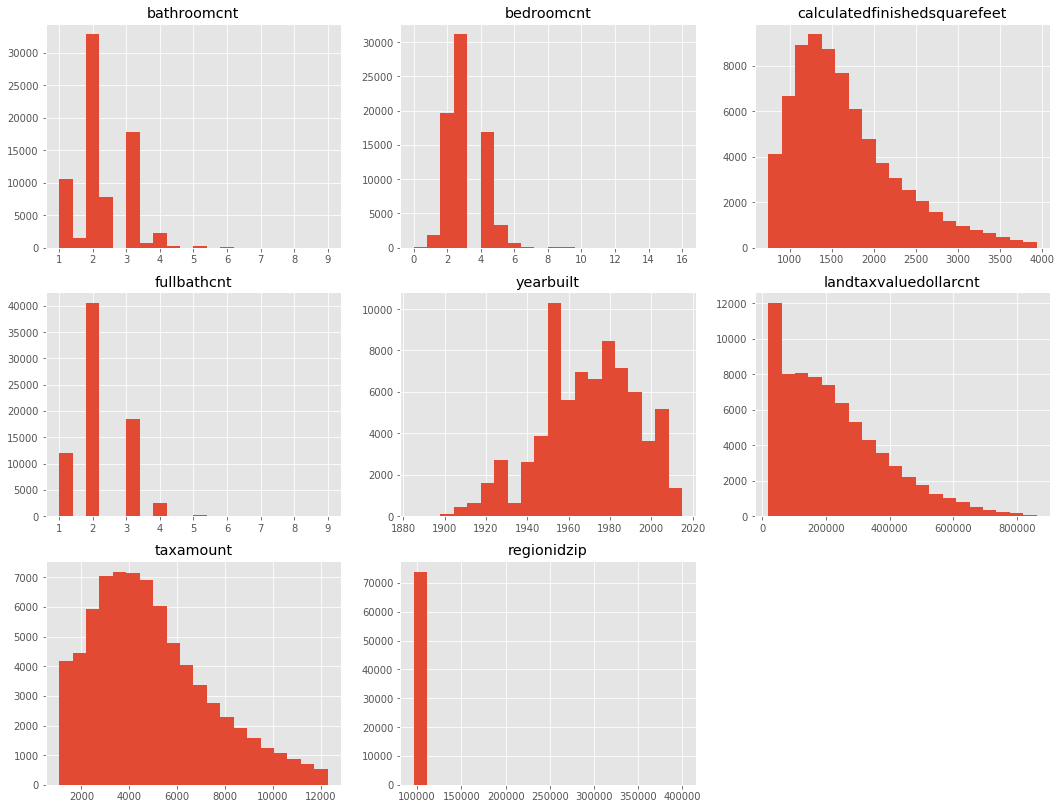

In [28]:
plt.figure(figsize=(18,14))
for i, col in enumerate(X_vars):  
    plot_number = i + 1 # i starts at 0, but plot nos should start at 1
    series = df[col]
    plt.subplot(3, 3, plot_number)
    plt.title(col)
    df[col].hist(bins=20)

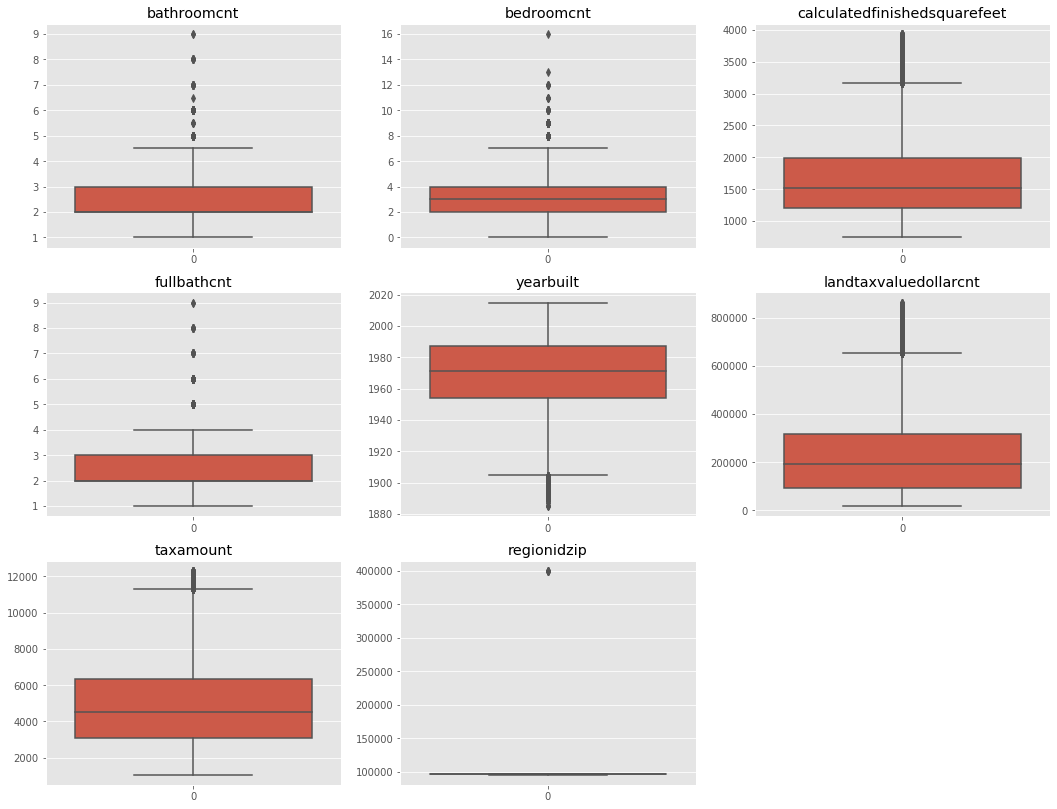

In [29]:
plt.figure(figsize=(18,14))
for plot_num, col in enumerate(X_vars):  
    plt.subplot(3, 3, plot_num + 1)
    plt.title(col)
    sns.boxplot(data=df[col])
# still showing outliers now... 

In [30]:
summarize_df(df)

Summary of Data

Rows & Columns:

(73946, 9)
Variables:

['logerror' 'bathroomcnt' 'bedroomcnt' 'calculatedfinishedsquarefeet'
 'fullbathcnt' 'yearbuilt' 'landtaxvaluedollarcnt' 'taxamount'
 'regionidzip']

Column Info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73946 entries, 0 to 90274
Data columns (total 9 columns):
logerror                        73946 non-null float64
bathroomcnt                     73946 non-null float64
bedroomcnt                      73946 non-null float64
calculatedfinishedsquarefeet    73946 non-null float64
fullbathcnt                     73946 non-null float64
yearbuilt                       73946 non-null float64
landtaxvaluedollarcnt           73946 non-null float64
taxamount                       73946 non-null float64
regionidzip                     73946 non-null float64
dtypes: float64(9)
memory usage: 8.1 MB
None

Numeric Summary Stats:

           logerror   bathroomcnt    bedroomcnt  calculatedfinishedsquarefeet  \
count  73946.000000  7394

In [31]:
df

,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,yearbuilt,landtaxvaluedollarcnt,taxamount,regionidzip
0,0.0953,2.5,3.0,1264.0,2.0,1986.0,76724.0,2015.06,97081.0
1,0.0198,1.0,2.0,777.0,1.0,1990.0,95870.0,2581.30,97083.0
4,0.0573,2.5,4.0,2415.0,2.0,1984.0,277000.0,5886.92,97084.0
5,0.0564,2.5,4.0,2882.0,2.0,1980.0,67539.0,3110.44,97089.0
6,0.0315,2.0,3.0,1772.0,2.0,1978.0,341000.0,5632.20,97089.0
7,0.0257,2.5,5.0,2632.0,2.0,1971.0,228475.0,6109.94,97089.0
8,0.0020,2.0,3.0,1292.0,2.0,1979.0,231297.0,5026.40,97091.0
9,0.0576,1.0,3.0,1385.0,1.0,1950.0,134251.0,3217.06,97104.0
11,0.0212,2.5,4.0,2735.0,2.0,1984.0,159892.0,4595.36,97097.0
12,0.0834,2.0,5.0,2085.0,2.0,1962.0,427000.0,6991.06,96383.0


#### BONUS:  Data standardization 
Create a new data frame that is the min-max normalization of the independent variable in the original data frame (+ the original dependent variable). You will normalize each of the numeric independent variables independently, i.e. using the min and max of each variable, not the min/max of the whole dataframe. Why? Regression is very sensitive to difference in units. It will be almost impossible to extract a meaningful linear regression model with such extreme differences in scale. For more context, see: https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc
You will use this dataframe in the future analysis.

In [32]:
norm_X = X.drop(['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet', 'fullbathcnt', 'yearbuilt', 'landtaxvaluedollarcnt', 'taxamount', 'regionidzip'], axis=1)
norm_X['bath'] = (X.bathroomcnt - X.bathroomcnt.min()) / (X.bathroomcnt.max() - X.bathroomcnt.min())
norm_X['bed'] = (X.bedroomcnt - X.bedroomcnt.min()) / (X.bedroomcnt.max() - X.bedroomcnt.min())
norm_X['totsqft'] = (X.calculatedfinishedsquarefeet - X.calculatedfinishedsquarefeet.min()) / (X.calculatedfinishedsquarefeet.max() - X.calculatedfinishedsquarefeet.min())
norm_X['fullbath'] = (X.fullbathcnt - X.fullbathcnt.min()) / (X.fullbathcnt.max() - X.fullbathcnt.min())
norm_X['year'] = (X.yearbuilt - X.yearbuilt.min()) / (X.yearbuilt.max() - X.yearbuilt.min())
norm_X['land'] = (X.landtaxvaluedollarcnt - X.landtaxvaluedollarcnt.min()) / (X.landtaxvaluedollarcnt.max() - X.landtaxvaluedollarcnt.min())
norm_X['tax'] = (X.taxamount - X.taxamount.min()) / (X.taxamount.max() - X.taxamount.min())
norm_X['zip'] = X.regionidzip
norm_X

,bath,bed,totsqft,fullbath,year,land,tax,zip
0,0.1875,0.1875,0.163591,0.125,0.776923,0.069212,0.084512,97081.0
1,0.0000,0.1250,0.011261,0.000,0.807692,0.091897,0.134981,97083.0
4,0.1875,0.2500,0.523616,0.125,0.761538,0.306505,0.429610,97084.0
5,0.1875,0.2500,0.669690,0.125,0.730769,0.058329,0.182143,97089.0
6,0.1250,0.1875,0.322490,0.125,0.715385,0.382334,0.406907,97089.0
7,0.1875,0.3125,0.591492,0.125,0.661538,0.249011,0.449488,97089.0
8,0.1250,0.1875,0.172349,0.125,0.723077,0.252355,0.352912,97091.0
9,0.0000,0.1875,0.201439,0.000,0.500000,0.137372,0.191646,97104.0
11,0.1875,0.2500,0.623710,0.125,0.761538,0.167752,0.314494,97097.0
12,0.1250,0.3125,0.420394,0.125,0.592308,0.484230,0.528022,96383.0


In [33]:
summarize_df(norm_X)

Summary of Data

Rows & Columns:

(73946, 8)
Variables:

['bath' 'bed' 'totsqft' 'fullbath' 'year' 'land' 'tax' 'zip']

Column Info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73946 entries, 0 to 90274
Data columns (total 8 columns):
bath        73946 non-null float64
bed         73946 non-null float64
totsqft     73946 non-null float64
fullbath    73946 non-null float64
year        73946 non-null float64
land        73946 non-null float64
tax         73946 non-null float64
zip         73946 non-null float64
dtypes: float64(8)
memory usage: 7.6 MB
None

Numeric Summary Stats:

               bath           bed       totsqft      fullbath          year  \
count  73946.000000  73946.000000  73946.000000  73946.000000  73946.000000   
mean       0.155122      0.190366      0.288612      0.146580      0.647969   
std        0.095271      0.062102      0.195594      0.095242      0.177394   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.

In [41]:
# Independent variables:
X_vars = ['bath','bed','totsqft', 'fullbath', 'year', 'land', 'tax', 'zip']

# Dependent (target) variable, it is continuous
target = ['logerror']

# Creating a melted version of train for visualization purposes
df_melted = pd.melt(df, id_vars=target, value_vars=X_vars, 
                    var_name='home_features', value_name='score')
X = norm_X.copy()                                                     
y = df[['logerror']]

KeyError: "The following 'value_vars' are not present in the DataFrame: ['bath', 'bed', 'fullbath', 'land', 'tax', 'totsqft', 'year', 'zip']"

In [42]:
df_melted.home_features.unique()

array(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'fullbathcnt', 'yearbuilt', 'landtaxvaluedollarcnt', 'taxamount',
       'regionidzip'], dtype=object)

### Data Exploration

Goal is to address each of the questions you posed in your planning & brainstorming through visual or statistical analysis.

When you have completed this step, you will have the findings from your analysis that will be used in your final report, the answers to your questions and your customer's questions that will reach the goal. 

#### Split data into training and test datasets

In [43]:
# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

#### Create a jointplot for each independent variable (normalized version) with the dependent variable. 

Be sure you have Pearson's r and p-value annotated on each plot.

In [44]:
X_vars, target

(['bath', 'bed', 'totsqft', 'fullbath', 'year', 'land', 'tax', 'zip'],
 ['logerror'])

ValueError: Could not interpret input 'bath'

<Figure size 1296x1008 with 0 Axes>

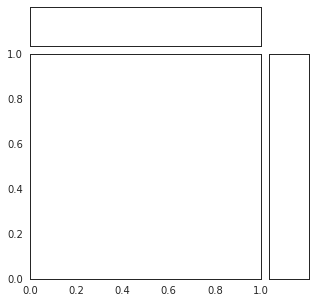

In [45]:
plt.figure(figsize=(18,14))

with sns.axes_style('white'):
    for i, col in enumerate(X_vars):  
        j = sns.jointplot(col, 'logerror', data=train, kind='reg', height=5);
        j.annotate(stats.pearsonr)

plt.show()
# All of the R^2 values are very low, way lower than .5. 
# So they are meaningless by themselves.

#### Create a feature plot using seaborn's PairGrid() of the interaction between each variable (dependent + independent). 

You may want to use a normalized dataframe (if you did that) or adjust the axis scale (set to logarithmic, e.g) so you can more clearly view the interactions.

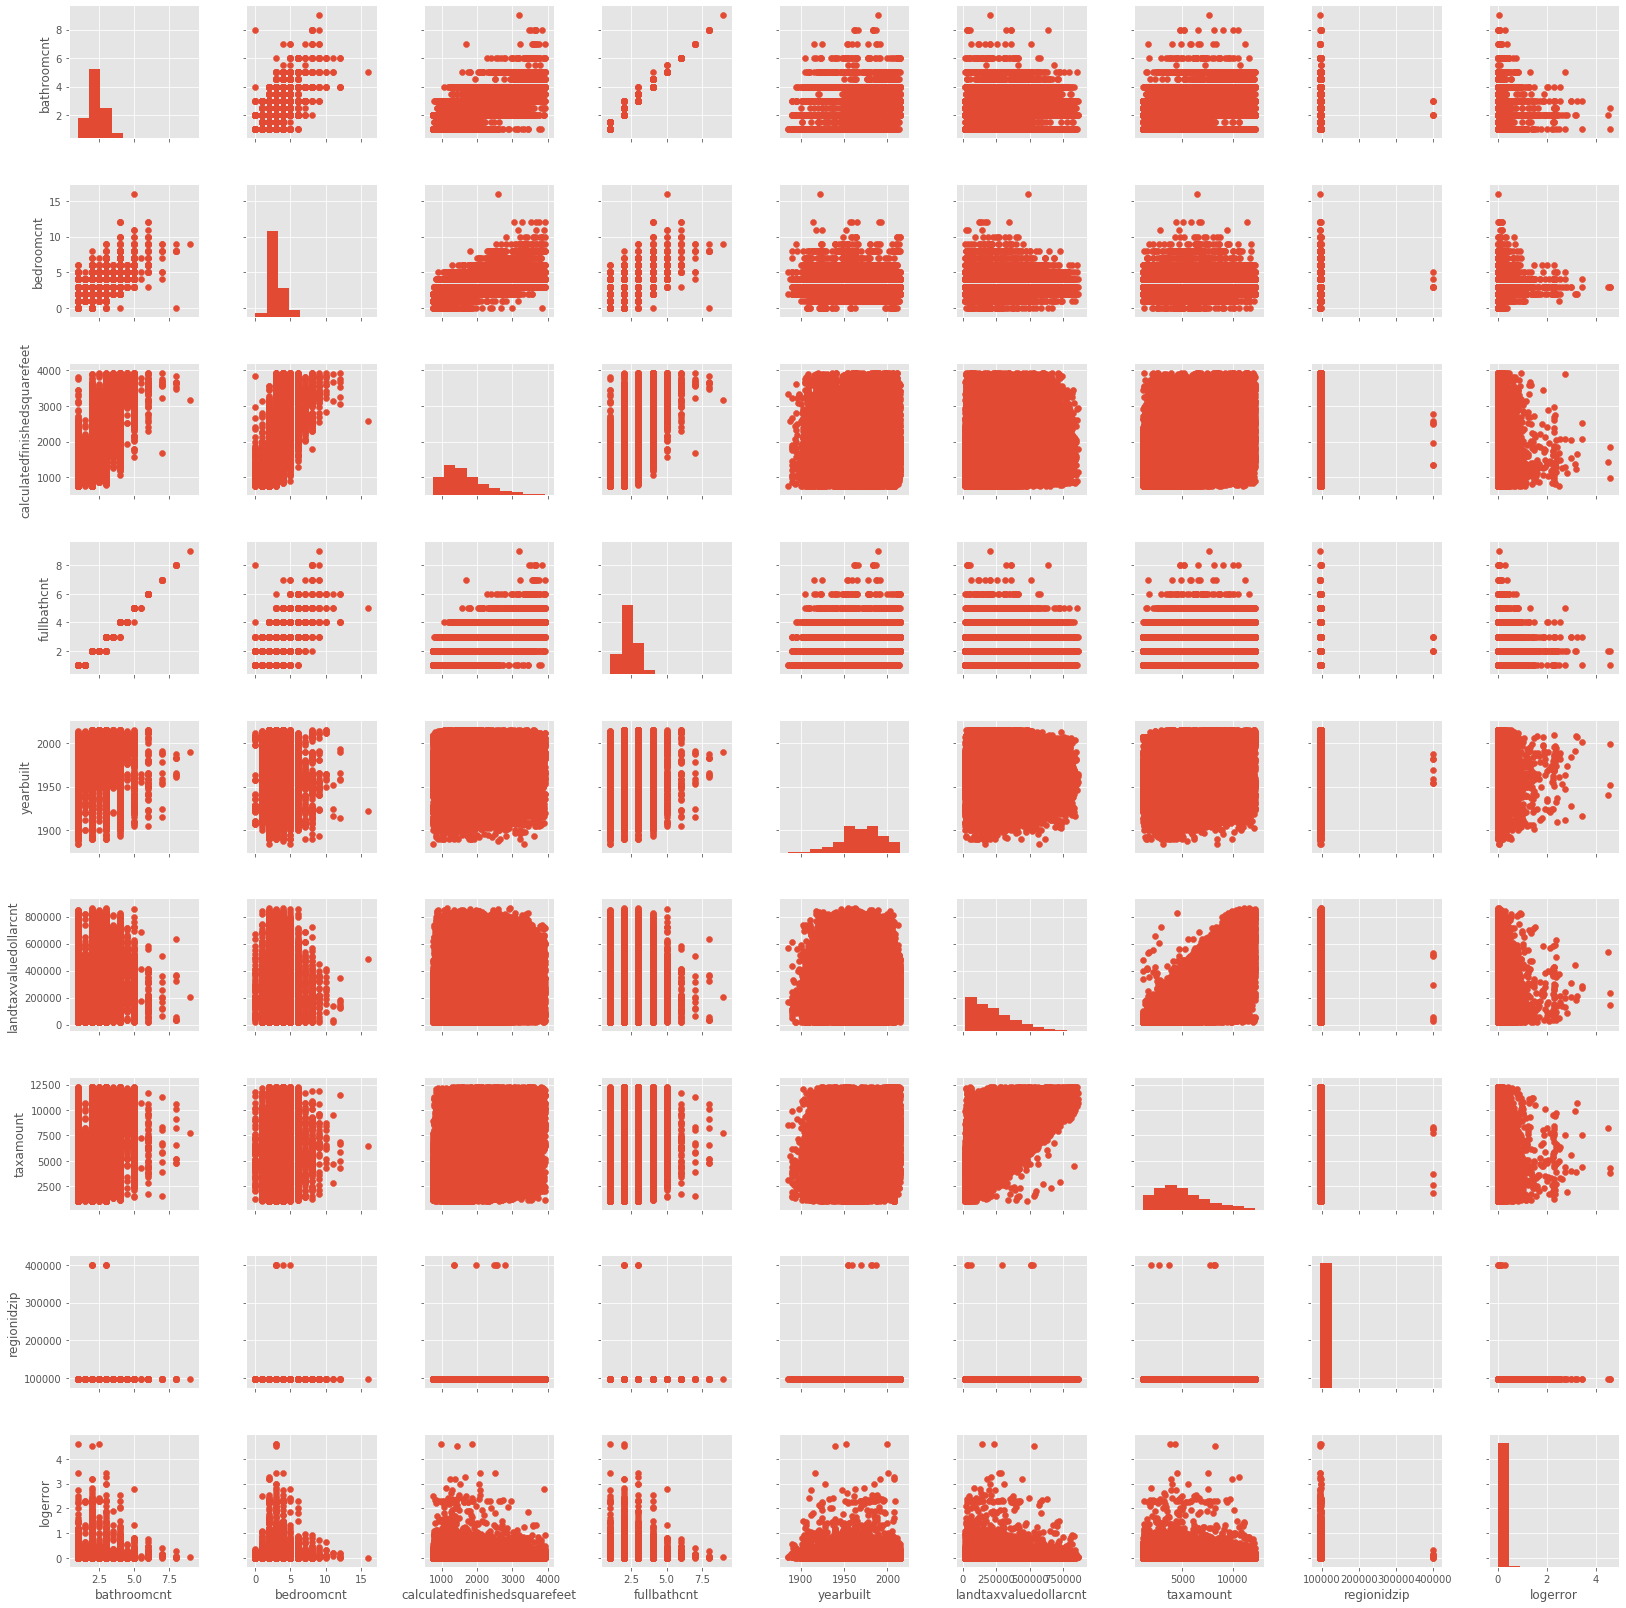

In [46]:
g = sns.PairGrid(train)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
# This shows that looking at the features like this is worthless

#### Create a heatmap of the correlation between each variable pair.

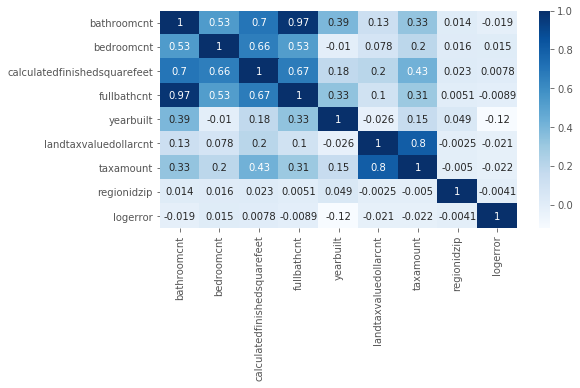

In [47]:
plt.figure(figsize=(8,4))
sns.heatmap(train.corr(), cmap='Blues', annot=True)
# The only rows/columns that are really useful in terms of finding drivers of logerror
# are the logerror row and column. 
# And the highest correlation between any feature and logerror is the year built, 
# but at only -0.12, far below a level of significance. 

#### Summarize your conclusions from all of these steps.  

All of this shows that looking at the data without grouping anything is meaningless.

#### Is the logerror significantly different for homes with 3 bedrooms vs those with 5 or more bedrooms? 
Run a t-test to test this difference.

In [48]:
train.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,yearbuilt,landtaxvaluedollarcnt,taxamount,regionidzip,logerror
17737,3.0,3.0,2144.0,3.0,1987.0,40741.0,3253.62,97319.0,0.0030
79524,2.0,2.0,1792.0,2.0,1940.0,561000.0,8129.13,96320.0,0.0460
16607,2.5,3.0,1977.0,2.0,1996.0,200808.0,3893.18,96974.0,0.0121
5301,2.5,4.0,1795.0,2.0,1990.0,410467.0,7804.22,96993.0,0.0161
66916,4.0,4.0,2835.0,4.0,1968.0,345437.0,6041.10,96965.0,0.0714


In [49]:
bed_max = df.bedroomcnt.max()
bed_min = df.bedroomcnt.min()
bed_max, bed_min 

(16.0, 0.0)

In [50]:
three_br = train[train.bed == (3-bed_min)/(bed_max-bed_min)]
five_br = train[train.bed >= (5-bed_min)/(bed_max-bed_min)]

from scipy.stats import ttest_ind
ttest_ind(five_br.logerror, three_br.logerror)

# Ttest_indResult(statistic=9.614493211028272, pvalue=7.49970753153216e-22)
# A t score of 9.6 means the groups are 9.6 times as different 
# from each other as they are within each other.

#     - The larger the t statistic, the more difference there is between 
#       the groups, the more likely it is that the results are repeatable, 
#       i.e. that the difference is significant.

#     - The smaller the score, the more similarity.

# So this shows that the three and five bedroom groups are significantly different
# from each other. So I need to group the number of bedrooms and work with that 
# aggragate. 

AttributeError: 'DataFrame' object has no attribute 'bed'

#### Do the same for another 2 samples you are interested in comparing (e.g. those with 1 bath vs. x baths)

In [51]:
bath_max = df.bathroomcnt.max()
bath_min = df.bathroomcnt.min()
bath_max, bath_min

(9.0, 1.0)

In [52]:
three_bath = train[train.bath == (3-bath_min)/(bath_max-bath_min)]
five_bath = train[train.bath >= (5-bath_min)/(bath_max-bath_min)]

ttest_ind(five_bath.logerror, three_bath.logerror)

# Ttest_indResult(statistic=9.823668696764043, pvalue=1.0469317493484346e-22)
# Another large difference, so I definitely need to group my features.

AttributeError: 'DataFrame' object has no attribute 'bath'

### Data Modeling

#### Feature Engineering & Selection

#### Are there new features you could create based on existing features that might be helpful? 

Come up with at least one possible new feature that is a calculation from 2+ existing variables. 

I went back and added the following features:

- rooms = bathroomcnt + bedroomcnt
- then drop bath, bed, and fullbath columns

In [45]:
df['rooms'] = df['bathroomcnt'] + df['bedroomcnt']
df = df.drop(['bathroomcnt', 'bedroomcnt', 'fullbathcnt'], axis=1)
df.head(3)

,logerror,calculatedfinishedsquarefeet,yearbuilt,landtaxvaluedollarcnt,taxamount,regionidzip,rooms
0,0.0953,1264.0,1986.0,76724.0,2015.06,97081.0,5.5
1,0.0198,777.0,1990.0,95870.0,2581.30,97083.0,3.0
4,0.0573,2415.0,1984.0,277000.0,5886.92,97084.0,6.5


In [46]:
X = df.drop(['logerror'], axis=1)

In [47]:
X.head(3)

,calculatedfinishedsquarefeet,yearbuilt,landtaxvaluedollarcnt,taxamount,regionidzip,rooms
0,1264.0,1986.0,76724.0,2015.06,97081.0,5.5
1,777.0,1990.0,95870.0,2581.30,97083.0,3.0
4,2415.0,1984.0,277000.0,5886.92,97084.0,6.5


In [48]:
X = X[['rooms', 'calculatedfinishedsquarefeet', 'landtaxvaluedollarcnt', 'yearbuilt', 'taxamount', 'regionidzip']]
X.head(3)

,rooms,calculatedfinishedsquarefeet,landtaxvaluedollarcnt,yearbuilt,taxamount,regionidzip
0,5.5,1264.0,76724.0,1986.0,2015.06,97081.0
1,3.0,777.0,95870.0,1990.0,2581.30,97083.0
4,6.5,2415.0,277000.0,1984.0,5886.92,97084.0


In [49]:
norm_X['rooms'] = (X.rooms - X.rooms.min()) / (X.rooms.max() - X.rooms.min())

In [50]:
norm_X = norm_X.drop(['bath', 'bed', 'fullbath'], axis=1)

In [51]:
norm_X = norm_X[['rooms', 'totsqft', 'land', 'year', 'tax', 'zip']]
norm_X.head(3)

,rooms,totsqft,land,year,tax,zip
0,0.225,0.163591,0.069212,0.776923,0.084512,97081.0
1,0.100,0.011261,0.091897,0.807692,0.134981,97083.0
4,0.275,0.523616,0.306505,0.761538,0.429610,97084.0


In [52]:
# Independent variables:
X_vars = ['rooms', 'totsqft', 'year', 'land', 'tax', 'zip']

# Dependent (target) variable, it is continuous
target = ['logerror']

# Creating a melted version of train for visualization purposes
df_melted = pd.melt(df, id_vars=target, value_vars=X_vars, 
                    var_name='home_features', value_name='score')
X = norm_X.copy()                                                    
y = df[['logerror']]

In [53]:
# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [54]:
if X_train.shape[0] == y_train.shape[0]:
    print("X & y train rows ARE equal")
else:
    print("X & y train rows ARE NOT equal")


if X_test.shape[0] == y_test.shape[0]:
    print("X & y test rows ARE equal")
else:
    print("X & y test rows ARE NOT equal")

if train.shape[1] == test.shape[1]:
    print("Number of columns in train & test ARE equal")
else:
    print("Number of columns in train & test ARE NOT equal")
 
train_split = train.shape[0] / (train.shape[0] + test.shape[0])
test_split = test.shape[0] / (train.shape[0] + test.shape[0])

print("Train Split: %.2f" % train_split)
print("Test Split: %.2f" % test_split)


X & y train rows ARE equal
X & y test rows ARE equal
Number of columns in train & test ARE equal
Train Split: 0.80
Test Split: 0.20


In [55]:
# See how combining room features changed the t-test.
rooms_max = df.rooms.max()
rooms_min = df.rooms.min()
rooms_max, rooms_min # (21.0, 1.0)

(21.0, 1.0)

In [56]:
three_rooms = train[train.rooms == (3-rooms_min)/(rooms_max-rooms_min)]
five_rooms = train[train.rooms >= (5-rooms_min)/(rooms_max-rooms_min)]

ttest_ind(five_rooms.logerror, three_rooms.logerror)

# Ttest_indResult(statistic=-10.622694341052586, pvalue=2.5102281817474788e-26)
# An even larger difference, so I definitely need to group my features by number of rooms.

Ttest_indResult(statistic=-10.622694341052586, pvalue=2.5102281817474788e-26)

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
/usr/local

<Figure size 1296x1008 with 0 Axes>

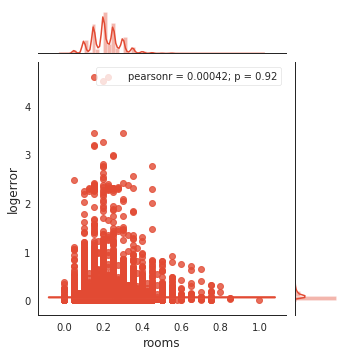

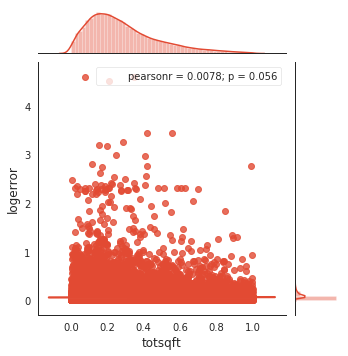

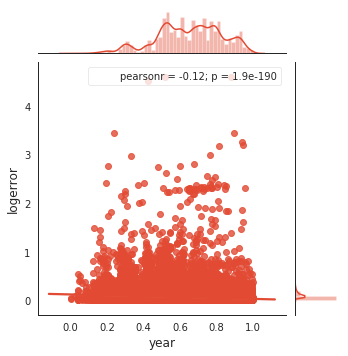

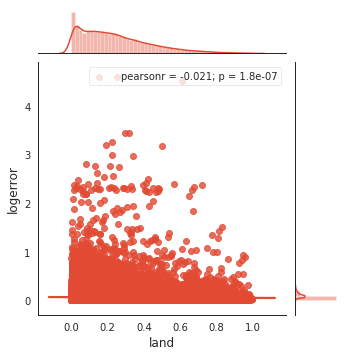

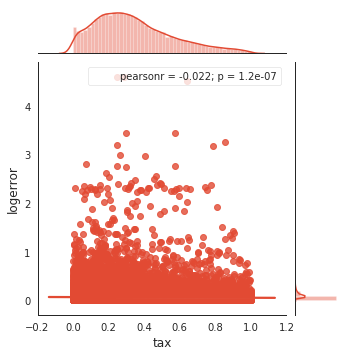

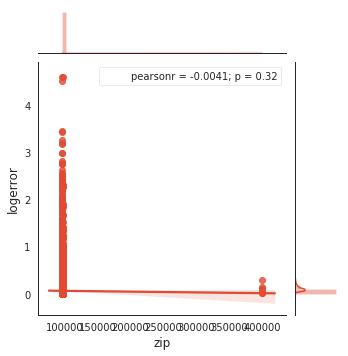

In [57]:
plt.figure(figsize=(18,14))

with sns.axes_style('white'):
    for i, col in enumerate(X_vars):  
        j = sns.jointplot(col, 'logerror', data=train, kind='reg', height=5);
        j.annotate(stats.pearsonr)

plt.show()
# All of the R^2 values are still very low, way lower than .5. 
# So they are still meaningless by themselves.

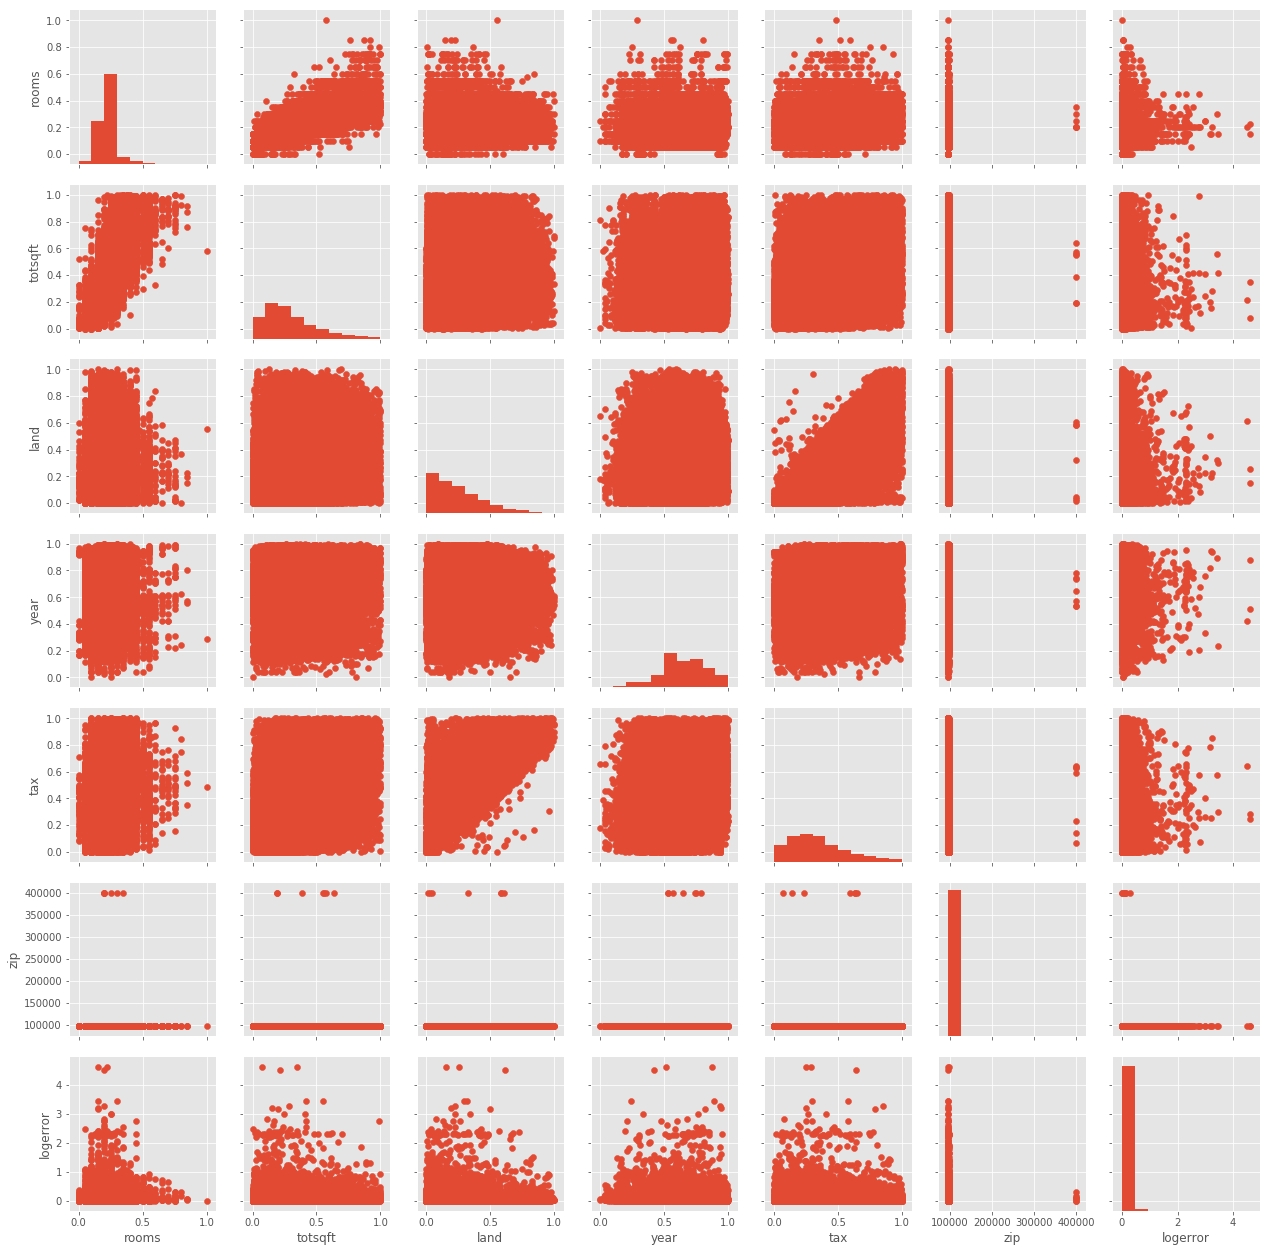

In [58]:
# This is roughly equivalent to sns.jointplot, but we see here that we have the
# flexibility to customize the type of the plots in each position.
g = sns.PairGrid(train)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
# This shows that looking at the features like this is worthless

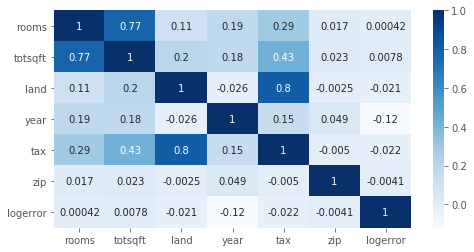

In [59]:
plt.figure(figsize=(8,4))
sns.heatmap(train.corr(), cmap='Blues', annot=True)

In [60]:
[[column, pearsonr(train[column], train.logerror)] for column in X_train] 

[['rooms', (0.00041619147843269396, 0.9193726581578389)],
 ['totsqft', (0.007843264866907878, 0.056439259367489766)],
 ['land', (-0.02145802389954475, 1.7939461720369796e-07)],
 ['year', (-0.12058587316193838, 1.916298575522669e-190)],
 ['tax', (-0.021764692572441176, 1.1958753037670222e-07)],
 ['zip', (-0.00407314980279283, 0.3218541032319301)]]

#### Use statsmodels ordinary least squares to assess the importance of each feature with respect to the target

In [61]:
ols_model = sm.OLS(y_train, X_train)
fit = ols_model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logerror   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     2338.
Date:                Wed, 27 Mar 2019   Prob (F-statistic):               0.00
Time:                        16:52:57   Log-Likelihood:                 35168.
No. Observations:               59156   AIC:                        -7.032e+04
Df Residuals:                   59150   BIC:                        -7.027e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
rooms          0.0048      0.011      0.426      0.670      -0.017       0.027
totsqft        0.0192      0.005      4.035      0.000       0.010       0.028
land          -0.0383      0.005     -7.472      0.000      -0.048      -0.028
year          -0.0989      0.003    -30.341      0.000      -0.105      -0.093
tax            0.0193      0.005      3.952      0.000       0.010       0.029
zip         1.272e-06   2.68e-08     47.500      0.000    1.22e-06    1.32e-06
==============================================================================
Omnibus:                    98079.547   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        104625071.117
Skew:                          11.135   Prob(JB):                         0.00
Kurtosis:                     207.820   Cond. No.                     2.09e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Summarize your conclusions and next steps from your analysis in above. 
What will you try when developing your model? (which features to use/not use/etc)

If the data is good for modeling, then our residuals will have certain characteristics. These characteristics are:

1. The data is “linear”. That is, the dependent variable is a linear function of independent variables and an error term e, and is largely dependent on characteristics 2-4. Think of the equation of a line in two dimensions: y = mx + b + e. yis the dependent or “response” variable, xis the input, mis the dimensional coefficient and bis the intercept (when x = 0). We can easily extend this “line” to higher dimensions by adding more inputs and coefficients, creating a hyperplane with the following form: y = a1\*x1+ a2\*x2+ … + an\*xn
2. Errors are normally distributed across the data. In other words, if you plotted the errors on a graph, they should take on the traditional bell-curve or Gaussian shape.
3. There is “homoscedasticity”. This means that the variance of the errors is consistent across the entire dataset. We want to avoid situations where the error rate grows in a particular direction. 
4. The independent variables are actually independent and not collinear. We want to ensure independence between all of our inputs, otherwise our inputs will affect each other, instead of our response.



Omnibus:	98079.547
Omnibus/Prob(Omnibus) – a test of the skewness and kurtosis of the residual. (Errors are normally distributed across the data. In other words, if you plotted the errors on a graph, they should take on the traditional bell-curve or Gaussian shape.) We hope to see a value close to *zero* which would indicate normalcy. 

Prob(Omnibus):	0.000
The Prob (Omnibus) performs a statistical test indicating the probability that the residuals are normally distributed. We hope to see something *close to 1* here. 

In this case Omnibus is hugely high and the Prob (Omnibus) is 
zero. A linear regression approach will not likely yield results as good as from a nonlinear approach.

Skew:	11.135
Skew – a measure of data symmetry. We want to see something close to *zero*, indicating the residual distribution is normal. Note that this value also drives the Omnibus. This result has a very large, and therefore terrible, skew.

Kurtosis:	207.820
Kurtosis – a measure of “peakiness”, or curvature of the data. Higher peaks lead to greater Kurtosis. Greater Kurtosis can be interpreted as a tighter clustering of residuals around zero, implying a better model with few outliers. But this is a terrible model, so I'm not sure what this means.

Durbin-Watson:	2.000
Durbin-Watson – tests for homoscedasticity. (There is “homoscedasticity”. This means that the variance of the errors is consistent across the entire dataset. We want to avoid situations where the error rate grows in a particular direction.). We hope to have a value *between 1 and 2*. In this case, the data yields a value of 2, not within limits.

Jarque-Bera (JB):	104625071.117
Jarque-Bera (JB)/Prob(JB) – like the Omnibus test in that it tests both skew and kurtosis. We hope to see in this test a confirmation of the Omnibus test. In this case we do not since the Omnibus test yielded 98079.547. 

Cond. No.	2.09e+06
Condition Number – This test measures the sensitivity of a function’s output as compared to its input. (The independent variables are actually independent and not collinear. We want to ensure independence between all of our inputs, otherwise our inputs will affect each other, instead of our response.) When we have multicollinearity, we can expect much higher fluctuations to small changes in the data, hence, we hope to see a relatively small number, something *below 30*. In this case we are over 2 million.

#### Train & Test Model

In [62]:
lm1 = LinearRegression()
print(lm1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)


In [63]:
lm1.fit(X_train[['rooms', 'totsqft']], y_train)
print(lm1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)


In [64]:
lm1_y_intercept = lm1.intercept_
print(lm1_y_intercept)

lm1_coefficients = lm1.coef_
print(lm1_coefficients)

[0.06433538]
[[-0.02464972  0.01292462]]


In [65]:
print('Multivariate - logerror = b + m1 * rooms + m2 * totsqft')
print('    y-intercept  (b): %.2f' % lm1_y_intercept)
print('    coefficient (m1): %.2f' % lm1_coefficients[0][0])
print('    coefficient (m2): %.2f' % lm1_coefficients[0][1])

Multivariate - logerror = b + m1 * rooms + m2 * totsqft
    y-intercept  (b): 0.06
    coefficient (m1): -0.02
    coefficient (m2): 0.01


#### Fit, predict (in-sample) & evaluate multiple linear regression models to find the best one.

- Make any changes as necessary to improve your model.

- Identify the best model after all training

- Compare the models by plotting the predictions of each model with actual values (see plot right above section 12 in 'Regression in Python' lesson

In [66]:
X_train.head(2)

,rooms,totsqft,land,year,tax,zip
17737,0.25,0.438849,0.026578,0.784615,0.194905,97319.0
79524,0.15,0.328746,0.642997,0.423077,0.629458,96320.0


In [67]:
y_pred_lm1 = lm1.predict(X_train.drop(columns=['land', 'year', 'tax', 'zip']))

In [68]:
mse_lm1 = mean_squared_error(y_train, y_pred_lm1)
print("lm1\n  mse: {:.3}".format(mse_lm1)) 

r2_lm1 = r2_score(y_train, y_pred_lm1)
print("  {:.2%} of the variance in the Zestimate's logerror can be explained by the total number of rooms and the total square feet.".format(r2_lm1))

lm1
  mse: 0.0181
  0.01% of the variance in the Zestimate's logerror can be explained by the total number of rooms and the total square feet.


##### Compare the 2 models
We can visualize the predictions by plotting the predictions vs the actual values:

(the predictions are a 1 x 83 two dimensional matrix, but we want just a single array of predictions. We can use the .ravel method to achieve this.)

Text(0.5, 1.0, 'Predicted vs Actual Log Error')

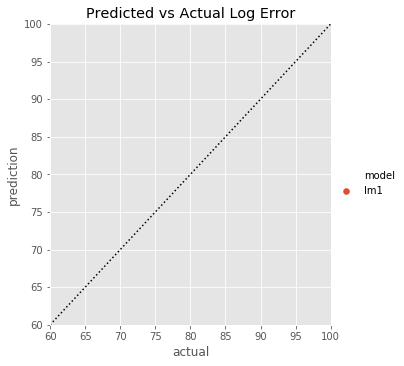

In [69]:
# This code is straight from the skeleton notebook that Maggie gave us
#         later, add back in... #'lm2': y_pred_lm2.ravel()})\

pd.DataFrame({'actual': y_train.logerror,
              'lm1': y_pred_lm1.ravel()})\
    .melt(id_vars=['actual'], var_name='model', value_name='prediction')\
    .pipe((sns.relplot, 'data'), x='actual', y='prediction', hue='model')

plt.plot([60, 100], [60, 100], c='black', ls=':')
plt.ylim(60, 100)
plt.xlim(60, 100)
plt.title('Predicted vs Actual Log Error')
# Here the line down the middle represents "perfect" prediction. 
# The further away from this line the are, the farther off the prediction was.
# ... something is wrong because this is a perfect match or one set of values is missing.

#### Predict & evaluate on out-of-sample data (test)    

- Plot the residuals from your out-of-sample predictions.

- Summarize your expectations about how you estimate this model will perform in production.

In [70]:
# Make predictions using the testing set
y_pred_lm1 = lm1.predict(X_test[['rooms', 'totsqft']])

In [71]:
mse_lm1 = mean_squared_error(y_test, y_pred_lm1)

print("Mean squared error of lm1: %.2f" % mse_lm1)

Mean squared error of lm1: 0.02


In [72]:
r2_lm1 = r2_score(y_test, y_pred_lm1)

print('{:.2%} of the variance in the logerror can be explained by the number of rooms and the total square footage.'
      .format(r2_lm1))

0.02% of the variance in the logerror can be explained by the number of rooms and the total square footage.


Text(0, 0.5, 'Residuals')

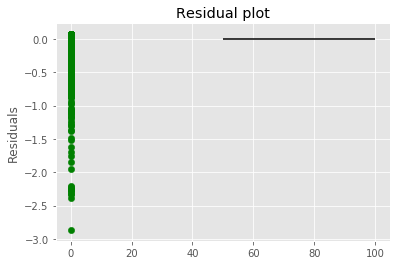

In [73]:
plt.scatter(y_pred_lm1, y_pred_lm1 - y_test, c='g', s=40)
plt.hlines(y=0, xmin=50, xmax=100)
plt.title("Residual plot")
plt.ylabel('Residuals')